In [1]:
!pip install tslearn

     |████████████████████████████████| 789 kB 5.2 MB/s            


In [2]:
import datetime
import io
import re
import numpy as np
import pandas as pd
import heapq
import boto3
import pyarrow.parquet as pq
import s3fs
import math
import matplotlib.pyplot as plt
import seaborn as sns
import tslearn

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

Matplotlib is building the font cache; this may take a moment.


#### Fetch data

In [3]:
# realized sales
def to_uri(bucket, key):
    """
    List all files under a S3 bucket
    :param bucket: (string) name of the S3 bucket
    :param key: (string) S3 key
    :return: (string) URI format
    """
    return f's3://{bucket}/{key}'

def read_multipart_parquet_s3(bucket, dir_path, prefix_filename='part-'):
    """
    Read a multipart parquet file (splitted) hosted on a S3 bucket, load and return as pandas dataframe. Note that only
    files with name starting with <prefix_filename> value are taken into account.
    :param bucket: (string) S3 source bucket
    :param dir_path: (string) full path to the folder that contains all parts within this S3 bucket
    :param prefix_filename: (string) Optional. Default is 'part-' which is what Spark generates. Only files with name
    starting with this value will be loaded
    :return: (pandas DataFrame) data loaded
    """
    fs = s3fs.S3FileSystem()
    s3_uri = to_uri(bucket, dir_path)
    data = pq.ParquetDataset(s3_uri, filesystem=fs).read().to_pandas(date_as_object=False)

    return data

def keys(bucket_name, prefix='/', delimiter='/'):
    prefix = prefix[1:] if prefix.startswith(delimiter) else prefix
    bucket = boto3.resource('s3').Bucket(bucket_name)
    return (_.key for _ in bucket.objects.filter(Prefix=prefix))

def week_id_to_date(week_id):
    """
    Turn a Decathlon week id to date
    :param week_id: (int or pd.Series) the week id or pandas column of week ids
    :return: (pd.Timestamp or pd.Series) the date or pandas column of dates
    """
    assert isinstance(week_id, (int, np.integer, pd.Series, list))
    if isinstance(week_id, (int, np.integer)):
        assert is_iso_format(week_id), f"`week_id` {week_id} doesn't follow conform YYYYWW format"
        return pd.to_datetime(str(week_id) + '-0', format='%G%V-%w') - pd.Timedelta(1, unit='W')
    else:
        if isinstance(week_id, (list)):
            week_id = pd.Series(week_id)
        for w in week_id:
            assert is_iso_format(w), f"Week_id {w} doesn't follow conform YYYYWW format"
        return pd.to_datetime(week_id.astype(str) + '-0', format='%G%V-%w') - pd.Timedelta(1, unit='W')
    
def is_iso_format(week_id: int) -> bool:
    """
    Checks if `week` has conform YYYYWW ISO 8601 format.
    :param week_id: (int or pd.Series) the week id or pandas column of week ids
    :return: (bool) wether `week_id` follows the expected format
    """
    assert isinstance(week_id, (int, np.int32, np.int64)), "week_id must be of type integer."
    pattern = "^20[0-9]{2}(0[1-9]|[1-4][0-9]|5[0-3])$"
    is_iso_format = re.match(pattern, str(week_id))

    return is_iso_format is not None

def date_to_week_id(date):
    """
    Turn a date to Decathlon week id
    :param date: (str, pd.Timestamp or pd.Series) the date or pandas column of dates
    :return: (int or pd.Series) the week id or pandas column of week ids
    """
    assert isinstance(date, (str, pd.Timestamp, pd.Series, datetime.date))
    if isinstance(date, (str, pd.Timestamp, datetime.date)):
        date = pd.Timestamp(date)
        if date.dayofweek == 6:  # If sunday, replace by next monday to get the correct iso week
            date = date + pd.Timedelta(1, unit='D')
        week_id = int(str(date.isocalendar()[0]) + str(date.isocalendar()[1]).zfill(2))
        return week_id
    else:
        df = pd.DataFrame({'date': pd.to_datetime(date)})
        df['dow'] = df['date'].dt.dayofweek
        df.loc[df['dow'] == 6, 'date'] = df.loc[df['dow'] == 6, 'date'] + pd.Timedelta(1, unit='D')
        df['week_id'] = df['date'].apply(lambda x: int(str(x.isocalendar()[0]) + str(x.isocalendar()[1]).zfill(2)))
        return df['week_id']

In [4]:
def apply_cold_start_reconstruction(df,
                                    df_model_week_sales,
                                    df_model_week_tree,
                                    rec_cold_start_length,
                                    rec_cold_start_group,
                                    avg_impl_period_duration=8
                                    ):
    """
    Create a fake sales history for models that started too recently.
    Args:
        df (pd.DataFrame): The sales of the time series pool on which we want to apply a cold-start
            reconstruction
        df_model_week_sales (pd.DataFrame): Sales of all available time series
        df_model_week_tree (pd.DataFrame): Tree structure information of all available time series
        rec_cold_start_length (int): The minimum expected size of each time series after reconstruction
        rec_cold_start_group (list): The list of aggregation keys (of the tree structure) on which
            to calculate the reconstruction properties
        avg_impl_period_duration (int): The average implementation period duration for Decathlon products
    Returns:
        complete_ts (pd.DataFrame): The sales of the time series pool including the reconstruction
    """
    # Create a complete TS dataframe
    all_model = df['model_id'].sort_values().unique()
    all_week = df_model_week_sales \
        .loc[df_model_week_sales['week_id'] <= df['week_id'].max(), 'week_id'] \
        .sort_values() \
        .unique()

    w, m = pd.core.reshape.util.cartesian_product([all_week, all_model])

    complete_ts = pd.DataFrame({'model_id': m, 'week_id': w})

    # Add dates
    complete_ts['date'] = week_id_to_date(complete_ts['week_id'])

    # Add cluster_keys info from df_model_week_tree
    complete_ts = pd.merge(complete_ts, df_model_week_tree[['model_id'] + rec_cold_start_group], how='left')
    # /!\ in very rare cases, the models are too old or too recent and do not have descriptions in d_sku
    complete_ts.dropna(subset=rec_cold_start_group, inplace=True)

    # Add current sales from df
    complete_ts = pd.merge(complete_ts, df, how='left')

    # Calculate the average sales per cluster and week from df_model_week_sales
    all_sales = pd.merge(df_model_week_sales, df_model_week_tree[['model_id'] + rec_cold_start_group], how='left')
    all_sales.dropna(subset=rec_cold_start_group, inplace=True)
    all_sales = all_sales.groupby(rec_cold_start_group + ['week_id', 'date']) \
        .agg(mean_cluster_sales_quantity=('sales_quantity', 'mean')) \
        .reset_index()

    # Ad it to complete_ts
    complete_ts = pd.merge(complete_ts, all_sales, how='left')

    # Compute the scale factor by row
    complete_ts['row_scale_factor'] = complete_ts['sales_quantity'] / complete_ts['mean_cluster_sales_quantity']

    # Compute the scale factor by model
    model_scale_factor = complete_ts \
        .groupby('model_id') \
        .agg(model_scale_factor=('row_scale_factor', 'mean')) \
        .reset_index()

    complete_ts = pd.merge(complete_ts, model_scale_factor, how='left')

    # have each model a scale factor?
    assert complete_ts[complete_ts.model_scale_factor.isnull()].shape[0] == 0

    # Compute a fake sales quantity by row (if unknow fill by 0)
    complete_ts['fake_sales_quantity'] = complete_ts['mean_cluster_sales_quantity'] * complete_ts['model_scale_factor']
    complete_ts['fake_sales_quantity'] = complete_ts['fake_sales_quantity'].fillna(0).astype(int)

    # Calculate real age & total length of each TS
    ts_start_end_date = complete_ts \
        .loc[complete_ts['sales_quantity'].notnull()] \
        .groupby(['model_id']) \
        .agg(start_date=('date', 'min'),
             end_date=('date', 'max')) \
        .reset_index()

    complete_ts = pd.merge(complete_ts, ts_start_end_date, how='left')

    complete_ts['age'] = ((pd.to_datetime(complete_ts['date']) - pd.to_datetime(complete_ts['start_date'])
                           ) / np.timedelta64(1, 'W')).astype(int) + 1

    complete_ts['length'] = ((pd.to_datetime(complete_ts['end_date']) - pd.to_datetime(complete_ts['date'])
                              ) / np.timedelta64(1, 'W')).astype(int) + 1

    # Update sales quantity from 'rec_cold_start_length' weeks ago to the end of the average implementation period duration
    cond = (complete_ts['length'] <= rec_cold_start_length) & (complete_ts['age'] <= avg_impl_period_duration)

    complete_ts['sales_quantity'] = np.where(cond, complete_ts['fake_sales_quantity'], complete_ts['sales_quantity'])
    complete_ts['is_rec'] = np.where(cond, 1, 0)

    # Format
    complete_ts = complete_ts[list(df) + ['is_rec']].dropna(subset=['sales_quantity']).reset_index(drop=True)
    complete_ts['sales_quantity'] = complete_ts['sales_quantity'].astype(int)

    return complete_ts


def apply_lockdowns_reconstruction(df_sales, df_sales_reconstructed):
    """
    Replaces the lockdown weeks of `df_sales` with the reconstructed ones of `df_sales_reconstructed`.

    Args:
        df_sales (pd.DataFrame): The initial sales dataframe
        df_sales_reconstructed (pd.DataFrame): The reconstructed sales dataframe

    Returns:
        pd.DataFrame with the same structure as `df_sales`, whose lockdown weeks have been
        replaced by the ones in `df_sales_reconstructed`
    """
    df_sales = pd.merge(df_sales, df_sales_reconstructed, how='left')
    df_sales['sales_quantity'] = np.where(df_sales['sales_quantity_reconstructed'].notnull(),
                                          df_sales['sales_quantity_reconstructed'],
                                          df_sales['sales_quantity'])
    df_sales.drop(columns='sales_quantity_reconstructed', inplace=True)
    return df_sales

def pad_to_cutoff(df_ts: pd.DataFrame,
                  cutoff: int,
                  col: str = 'sales_quantity'
                  ) -> pd.DataFrame:
    """
    Forward fills with zeros time series in Pandas DataFrame up to week cutoff.

    The function will complete the dataframe for all models (`model_id`) with a frequency
    of 1 week, up to week_id cutoff (excluding it) on the column `col` with value = 0.
    The input dataframe must include columns ['model_id', 'week_id', 'date'].

    Args:
        df_ts (pd.DataFrame): Timeseries DataFrame
        cutoff (int): ISO 8601 Format Week id (YYYYWW) to forward fill to
        col (str): Name of the column to fill

    Returns:
        df (pd.DataFrame): Padded DataFrame
    """
    assert is_iso_format(cutoff)
    assert isinstance(cutoff, (int, np.int64))
    assert isinstance(df_ts, pd.DataFrame)
    assert pd.api.types.is_datetime64_any_dtype(df_ts['date'])
    assert set(df_ts.columns) == set(['model_id', 'week_id', 'date', 'channel', col])

    # Limiting dataset to avoid errors if we have data further than cutoff
    df_ts = df_ts[df_ts['week_id'] < cutoff]
    # Add the cutoff weekend to all models to put a limit for the bfill
    models = df_ts['model_id'].unique()
    test_cutoff_date = week_id_to_date(cutoff)
    md, cu = pd.core.reshape.util.cartesian_product([models, [cutoff]])
    df_ts_tail = pd.DataFrame({"model_id": md, "week_id": cu})
    df_ts_tail['date'] = test_cutoff_date
    df_ts_tail[col] = 0
    df = df_ts.append(df_ts_tail)

    # Backfill for the cutoff week
    df = df.set_index('date').groupby('model_id').resample('1W').asfreq().fillna(0)

    # Getting the df back to its original form
    df.drop(['model_id'], axis=1, inplace=True)
    df.reset_index(inplace=True)
    df['week_id'] = date_to_week_id(df['date'])

    # Getting rid of the cutoff week
    df = df[df['week_id'] < cutoff]
    df[col] = df[col].astype(int)

    return df

In [5]:
# get product nature information
sku = read_multipart_parquet_s3('fcst-clean-prod/datalake', 'd_sku', prefix_filename='part-')
sku['rank'] = sku.groupby(by='mdl_num_model_r3')['rs_technical_date'].rank(method='first',ascending=False)
sku['rank'] = sku['rank'].astype(int)

sku = sku[(sku.mdl_num_model_r3.isna()==False) & (sku['rank'] < 2)][['mdl_num_model_r3','product_nature_label']].fillna('UNDEFINED').drop_duplicates()
sku.mdl_num_model_r3 = sku.mdl_num_model_r3.apply(lambda x: int(x))
sku.columns = ['model_id','product_nature']

In [6]:
cutoff = 202138
# shutdown reconstructed sales
reconstructed_sales_lockdowns = read_multipart_parquet_s3('fcst-workspace/forecast-cn/fcst-refined-demand-forecast-dev',
                                           'global/reconstructed_sales_lockdowns.parquet', prefix_filename='part-')

# Sales refining
df_sales = read_multipart_parquet_s3('fcst-workspace/forecast-cn/fcst-refined-demand-forecast-dev',
                                     'global/model_week_sales', prefix_filename='part-')
#df_sales = df_sales.groupby(by=['model_id','week_id','date'],as_index=False).agg({'sales_quantity':'sum'})
df_sales = df_sales[df_sales.channel == 'online']
df_sales = df_sales[df_sales['week_id'] < cutoff]
df_sales = apply_lockdowns_reconstruction(df_sales, reconstructed_sales_lockdowns)
df_weekly_sales = df_sales

# MRP refining
df_mrp = read_multipart_parquet_s3('fcst-workspace/forecast-cn/fcst-refined-demand-forecast-dev',
                                   'global/model_week_mrp', prefix_filename='part-')
df_mrp = df_mrp[df_mrp['week_id'] == cutoff]

# Tree refining
df_tree = read_multipart_parquet_s3('fcst-workspace/forecast-cn/fcst-refined-demand-forecast-dev',
                                    'global/model_week_tree', prefix_filename='part-')
df_tree = df_tree[df_tree['week_id'] == cutoff]

# Limiting Sales data to MRP active models
df_sales = pd.merge(df_sales, df_mrp.loc[df_mrp['is_mrp_active'], ['model_id']])

# Pad to cutoff Sales data
df_sales = pad_to_cutoff(df_sales, cutoff)

In [7]:
df_sales = apply_cold_start_reconstruction(df_sales,
                                           df_weekly_sales,
                                           df_tree,
                                           156,['family_id'],8)

### Part I - Segment with 2020 sales only

#### Feature Engineering

In [8]:
df_sales['year'] = df_sales['week_id'].apply(lambda x:int(str(x)[:4]))
#df_sales['week'] = df_sales['week_id'].apply(lambda x:int(str(x)[-2:]))

In [9]:
sales = df_sales[df_sales.year == 2020].groupby(by=['model_id'], as_index=False).agg({'sales_quantity':lambda x:list(x)})

In [10]:
sales['max_sales'] = sales['sales_quantity'].apply(lambda x:max(x))
sales['min_sales'] = sales['sales_quantity'].apply(lambda x:min(x))
sales['mean_sales'] = sales['sales_quantity'].apply(lambda x:np.mean(x))

# remove records with no sales the whole year
#sales = sales[sales['max_sales'] > 0]

sales['max_sales_week'] = sales['sales_quantity'].apply(lambda x:x.index(max(x)))
sales['min_sales_week'] = sales['sales_quantity'].apply(lambda x:x.index(min(x)))

thres = 0.2
sales['num_peek_sales'] = sales['sales_quantity'].apply(lambda list_:len([x for x in list_ if x >= max(list_ )*(1-thres)]))
sales['num_low_sales'] = sales['sales_quantity'].apply(lambda list_:len([x for x in list_ if x <= (min(list_ )+1)*(1+thres)]))

#sales['avg_peek_weekid'] = sales['sales_quantity'].apply(lambda list_:round(np.mean([list_.index(i) for i in list_ if i >= max(list_)*(1-)]),0))
#sales['avg_low_weekid'] = sales['sales_quantity'].apply(lambda list_:round(np.mean([list_.index(i) for i in list_ if i >= (min(list_ )+1)*(1+thres)]),0))
#sales['avg_peek_weekid'] = sales['sales_quantity'].apply(lambda list_:round(np.mean(list(map(list_.index, heapq.nlargest(15,list_)))),0))
#sales['avg_low_weekid'] = sales['sales_quantity'].apply(lambda list_:round(np.mean(list(map(list_.index, heapq.nsmallest(15,list_)))),0))
#sales['avg_low_weekid'] = sales['avg_low_weekid'].fillna(0)

sales['std_sales'] = sales['sales_quantity'].apply(lambda i:[(x-min(i))/((max(i)+0.001)-(min(i)+0.0001)) for x in i]).apply(lambda x:np.std(x))
#sales['std_sales'] = sales['sales_quantity'].apply(lambda x:np.std(x))
sales['std_sales_g'] = [1 if i <= 10 else 0 for i in sales['std_sales']]

#sales['max_min_index'] = round((sales['max_sales'] - sales['min_sales'])/sales['mean_sales'],1).fillna(0)
#sales['max_min_difference_g'] = ((sales.max_min_difference-sales.max_min_difference.min())/(sales.max_min_difference.max()-sales.max_min_difference.min())).apply(lambda x:round(x,1))

In [11]:
features = [
    'max_sales_week',
    'min_sales_week',
    'num_peek_sales',
    'num_low_sales',
    'std_sales',
    #'avg_peek_weekid',
    #'avg_low_weekid',
    #'max_min_index'
]
df_features = sales[['model_id']].drop_duplicates()\
.merge(sales[['model_id'] + features], on='model_id', how='left')\

df_features = df_features.set_index('model_id')

#### Modeling

In [12]:
X = np.array(df_features)
kmeans = KMeans(n_clusters=5, random_state=1124).fit(X)

label = kmeans.predict(X)
df_features['label'] = label
df_features = df_features.reset_index()

#### Analysis

In [13]:
df_features.label.value_counts()

0    3331
3    1263
1    1206
4     530
2     209
Name: label, dtype: int64

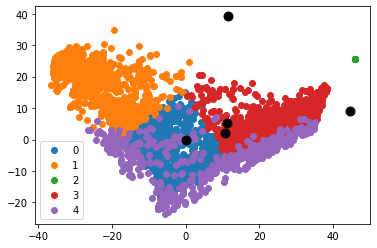

In [14]:
pca = PCA(2)
df = pca.fit_transform(X)

centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [15]:
sales = sales.merge(df_features[['model_id','label']],on='model_id',how='left').merge(sku,on='model_id',how='left')

---label 0---


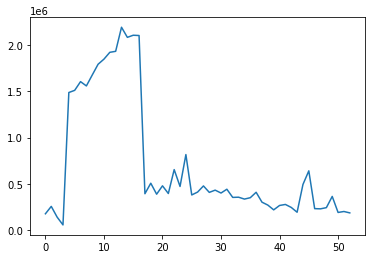

---label 1---


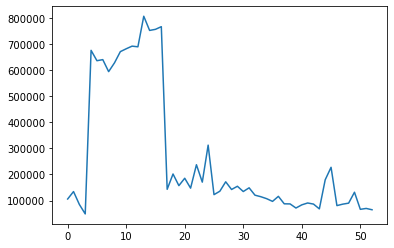

---label 3---


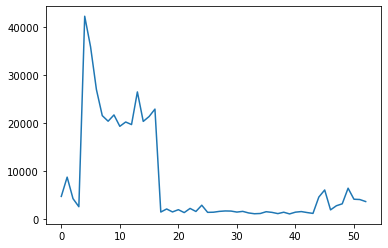

---label 4---


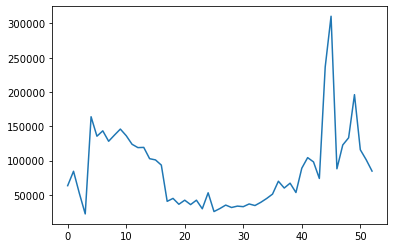

---label 2---


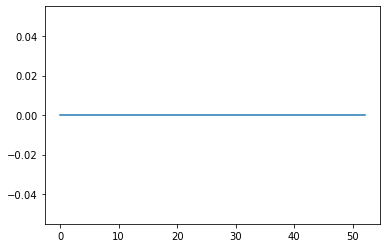

In [16]:
for label in sales.label.unique():
    print(f'---label {label}---')
    plt.plot(np.sum(sales[sales.label == label]['sales_quantity'].tolist(),axis=0))
    plt.show()

<AxesSubplot:>

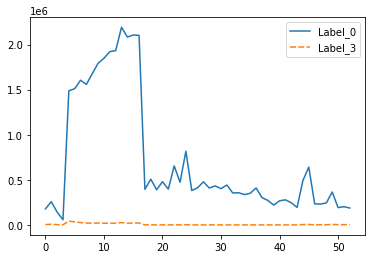

In [17]:
plot = pd.DataFrame({'Label_0':np.sum(sales[sales.label == 0]['sales_quantity'].tolist(),axis=0),
                     'Label_1':np.sum(sales[sales.label == 1]['sales_quantity'].tolist(),axis=0),
                     'Label_2':np.sum(sales[sales.label == 2]['sales_quantity'].tolist(),axis=0),
                     'Label_3':np.sum(sales[sales.label == 3]['sales_quantity'].tolist(),axis=0),
                     'Label_4':np.sum(sales[sales.label == 4]['sales_quantity'].tolist(),axis=0),
                     #'Label_5':np.sum(sales[sales.label == 5]['sales_quantity'].tolist(),axis=0)
                    })
sns.lineplot(data=plot)

<AxesSubplot:>

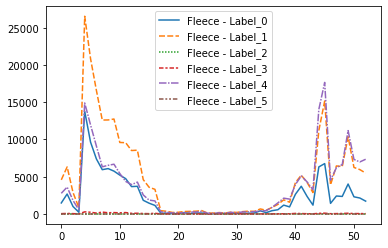

In [18]:
plot = pd.DataFrame({'Fleece - Label_0':np.sum(sales[(sales.label == 0) & (sales.product_nature == 'FLEECE')]['sales_quantity'].tolist(),axis=0),
                     'Fleece - Label_1':np.sum(sales[(sales.label == 1) & (sales.product_nature == 'FLEECE')]['sales_quantity'].tolist(),axis=0),
                     'Fleece - Label_2':np.sum(sales[(sales.label == 2) & (sales.product_nature == 'FLEECE')]['sales_quantity'].tolist(),axis=0),
                     'Fleece - Label_3':np.sum(sales[(sales.label == 3) & (sales.product_nature == 'FLEECE')]['sales_quantity'].tolist(),axis=0),
                     'Fleece - Label_4':np.sum(sales[(sales.label == 4) & (sales.product_nature == 'FLEECE')]['sales_quantity'].tolist(),axis=0),
                     'Fleece - Label_5':np.sum(sales[(sales.label == 5) & (sales.product_nature == 'FLEECE')]['sales_quantity'].tolist(),axis=0)
                    })
sns.lineplot(data=plot)

In [19]:
prod_nature = 'DOWN JACKET'
sales[sales.product_nature == prod_nature].groupby(by='label', as_index=False).agg({'model_id':'count',
                                                                                    'max_sales_week':'mean',
                                                                                    'min_sales_week':'mean',
                                                                                    'num_peek_sales':'mean',
                                                                                    'num_low_sales':'mean',
                                                                                    'std_sales':'mean',
                                                                                    'avg_low_weekid':'mean',
                                                                                    'avg_peek_weekid':'mean',
                                                                                    'max_min_index':'mean'
                                                                            })

SpecificationError: Column(s) ['avg_low_weekid', 'avg_peek_weekid', 'max_min_index'] do not exist

In [ ]:
prod_nature = 'FLEECE'
sales[f'is_{prod_nature}'] = [1 if i == prod_nature else 0 for i in sales.product_nature]
sales[sales.label == 3].groupby(by=f'is_{prod_nature}', as_index=False).agg({'max_sales_week':'median',
                                                                             'min_sales_week':'median',
                                                                             'num_peek_sales':'median',
                                                                             'num_low_sales':'median',
                                                                             'std_sales':'median',
                                                                             'avg_low_weekid':'mean',
                                                                             'avg_peek_weekid':'mean'
                                                                            })

In [94]:
# get sports information for segmentation analysis
sports = pd.read_csv('additional_datasource/sports_mapping.csv')

df_features = df_features.merge(df_tree[['model_id','family_id','family_label','product_nature_label']], on='model_id', how='left')\
.merge(sports[['family_id','sports']], on='family_id', how='left')

df_features.groupby(by=['label','sports','family_label','product_nature_label'],as_index=False).agg({'model_id':'count'}).to_csv('group_sports_dis.csv',index=False)

### Part II - Segment with sales in the past 52 weeks

In [97]:
def get_week_id(str_,step):
    str_ = str(str_)
    year = int(str_[:4])
    week = int(str_[4:])
    step = step - 1
    if week + step <= 52:
        if week+step < 10:
            return int(str(year) + '0' +str(week + step))
        else:
            return int(str(year) + str(week + step))
    else:
        round_ = math.floor((week + step) / 52)
        year = year + round_
        week = week + step - 52 * round_
        if week < 10:
            return int(str(year) + '0' + str(week))
        else:
            return int(str(year) + str(week))

In [98]:
sales = df_sales[(df_sales.week_id >= 202038)].groupby(by=['model_id'], as_index=False).agg({'sales_quantity':lambda x:list(x)})

In [ ]:
'''
* max_sales
* min_sales
* max_sales_week
* min_sales_week
* num_peek_sales
* num_low_sales
* std_sales
'''
sales['max_sales'] = sales['sales_quantity'].apply(lambda x:max(x))
sales['min_sales'] = sales['sales_quantity'].apply(lambda x:min(x))

# remove records with no sales the whole year
sales = sales[sales['max_sales'] > 0]

sales['max_sales_week'] = sales['sales_quantity'].apply(lambda x:x.index(max(x)))
sales['min_sales_week'] = sales['sales_quantity'].apply(lambda x:x.index(min(x)))

thres = 0.2
sales['num_peek_sales'] = [len([x for x in i[0] if x >= i[1]*(1-thres)]) for i in zip(sales['sales_quantity'], sales.max_sales)]
sales['num_low_sales'] = [len([x for x in i[0] if x <= (i[1]+1)*(1+thres)]) for i in zip(sales['sales_quantity'], sales.min_sales)]

sales['std_sales'] = sales['sales_quantity'].apply(lambda x:np.std(x))
sales['std_sales_g'] = [1 if i <= 10 else 0 for i in sales['std_sales']]

In [100]:
features = ['max_sales_week','min_sales_week','num_peek_sales','num_low_sales','std_sales_g']
df_features = sales[['model_id']].drop_duplicates()\
.merge(sales[['model_id'] + features], on='model_id', how='left')\

df_features = df_features.set_index('model_id')

In [101]:
df_features.head(2)

,max_sales_week,min_sales_week,num_peek_sales,num_low_sales,std_sales_g
model_id,,,,,
720719,32,9,4,7,1
863881,28,38,2,10,1


In [102]:
X = np.array(df_features)
kmeans = KMeans(n_clusters=4, random_state=1124).fit(X)

label = kmeans.predict(X)
df_features['label'] = label
df_features = df_features.reset_index()

In [103]:
df_features.label.value_counts()

2    2532
1    2029
0     975
3     840
Name: label, dtype: int64

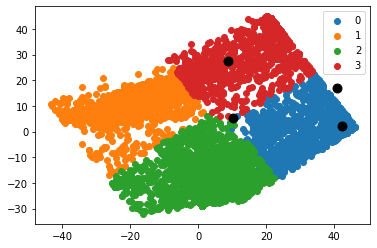

In [104]:
pca = PCA(2)
df = pca.fit_transform(X)

centroids = kmeans.cluster_centers_
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [105]:
sales = sales.merge(df_features[['model_id','label']],on='model_id',how='left')

---label 2---


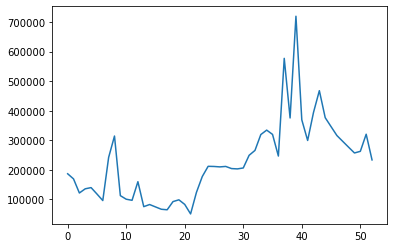

---label 1---


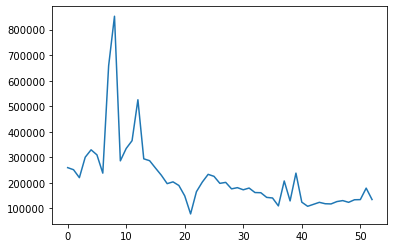

---label 3---


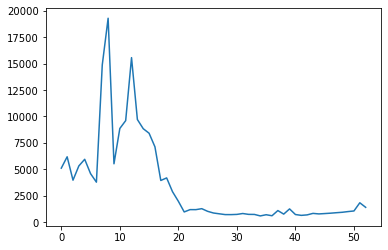

---label 0---


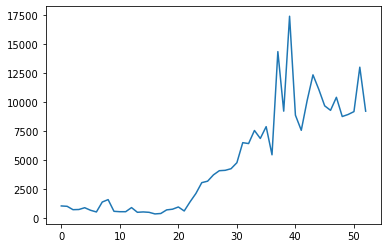

In [106]:
for label in sales.label.unique():
    print(f'---label {label}---')
    plt.plot(np.sum(sales[sales.label == label]['sales_quantity'].tolist(),axis=0))
    plt.show()

<AxesSubplot:>

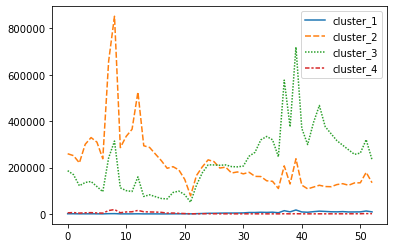

In [107]:
plot = pd.DataFrame({'cluster_1':np.sum(sales[sales.label == 0]['sales_quantity'].tolist(),axis=0),
              'cluster_2':np.sum(sales[sales.label == 1]['sales_quantity'].tolist(),axis=0),
              'cluster_3':np.sum(sales[sales.label == 2]['sales_quantity'].tolist(),axis=0),
              'cluster_4':np.sum(sales[sales.label == 3]['sales_quantity'].tolist(),axis=0),                     
                    })
sns.lineplot(data=plot)

#### Archive

In [110]:
# version 106
from sklearn.cluster import KMeans

def time_series_segmentation(df_sales, cluster_num=5):
    df_sales['year'] = df_sales['week_id'].apply(lambda x:int(str(x)[:4]))
    sales = df_sales[df_sales.year == 2020].groupby(by=['model_id'],as_index=False).agg({'sales_quantity':lambda x:list(x)})

    sales['max_sales'] = sales['sales_quantity'].apply(lambda x:max(x))
    sales['min_sales'] = sales['sales_quantity'].apply(lambda x:min(x))

    sales['max_sales_week'] = sales['sales_quantity'].apply(lambda x:x.index(max(x)))
    sales['min_sales_week'] = sales['sales_quantity'].apply(lambda x:x.index(min(x)))

    thres = 0.2
    sales['num_peek_sales'] = [len([x for x in i[0] if x >= i[1]*(1-thres)]) for i in zip(sales['sales_quantity'], sales.max_sales)]
    sales['num_low_sales'] = [len([x for x in i[0] if x <= (i[1]+1)*(1+thres)]) for i in zip(sales['sales_quantity'], sales.min_sales)]

    sales['std_sales'] = sales['sales_quantity'].apply(lambda x:np.std(x))
    sales['std_sales_g'] = [1 if i <= 10 else 0 for i in sales['std_sales']]
    
    features = ['max_sales_week','min_sales_week','num_peek_sales','num_low_sales','std_sales_g']
    df_features = sales[['model_id']].drop_duplicates().merge(sales[['model_id'] + features], on='model_id', how='left')
    df_features = df_features.set_index('model_id')

    # Modeling
    X = np.array(df_features)
    kmeans = KMeans(n_clusters=cluster_num, random_state=1124).fit(X)
    df_features['seasonality_label'] = kmeans.predict(X)
    df_features = df_features.reset_index()
    
    df_segmentation = df_features[['model_id','seasonality_label']]

    return df_segmentation

In [45]:
# version 108
from sklearn.cluster import KMeans
import heapq

def time_series_segmentation(df_sales, cluster_num=6):
    df_sales['year'] = df_sales['week_id'].apply(lambda x:int(str(x)[:4]))
    sales = df_sales[df_sales.year == 2020].groupby(by=['model_id'],as_index=False).agg({'sales_quantity':lambda x:list(x)})

    sales['max_sales'] = sales['sales_quantity'].apply(lambda x:max(x))
    sales['min_sales'] = sales['sales_quantity'].apply(lambda x:min(x))
    sales['mean_sales'] = sales['sales_quantity'].apply(lambda x:np.mean(x))

    sales['max_sales_week'] = sales['sales_quantity'].apply(lambda x:x.index(max(x)))
    sales['min_sales_week'] = sales['sales_quantity'].apply(lambda x:x.index(min(x)))

    thres = 0.2
    sales['num_peek_sales'] = sales['sales_quantity'].apply(lambda list_:len([x for x in list_ if x >= max(list_ )*(1-thres)]))
    sales['num_low_sales'] = sales['sales_quantity'].apply(lambda list_:len([x for x in list_ if x <= (min(list_ )+1)*(1+thres)]))

    sales['avg_peek_weekid'] = sales['sales_quantity'].apply(lambda list_:round(np.mean(list(map(list_.index, 
                                                                                                 heapq.nlargest(15,list_)))),0))
    sales['avg_low_weekid'] = sales['sales_quantity'].apply(lambda list_:round(np.mean(list(map(list_.index, 
                                                                                                heapq.nsmallest(15,list_)))),0))
    sales['avg_low_weekid'] = sales['avg_low_weekid'].fillna(0)

    sales['std_sales'] = sales['sales_quantity'].apply(lambda i:[(x-min(i))/((max(i)+0.001)-(min(i)+0.0001)) for x in i]).apply(lambda x:np.std(x))

    sales['max_min_index'] = round((sales['max_sales'] - sales['min_sales'])/sales['mean_sales'],1).fillna(0)
    
    features = ['max_sales_week','min_sales_week','num_peek_sales','num_low_sales','std_sales',
                'avg_peek_weekid','avg_low_weekid','max_min_index']
    df_features = sales[['model_id']].drop_duplicates().merge(sales[['model_id'] + features], on='model_id', how='left')
    df_features = df_features.set_index('model_id')

    # Modeling
    X = np.array(df_features)
    kmeans = KMeans(n_clusters=cluster_num, random_state=1124).fit(X)
    df_features['seasonality_label'] = kmeans.predict(X)
    df_features = df_features.reset_index()
    
    df_segmentation = df_features[['model_id','seasonality_label']]

    return df_segmentation